In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from pykalman import KalmanFilter
import requests
import statsmodels.api as sm
import scipy.optimize as spop

1)Cointegration Analysis: Cointegration is a statistical property that allows for a long-term relationship between two time series, even if they may not move perfectly together. Pairs with cointegrated prices are often considered more robust for pairs trading.

2)Engle-Granger Test:This is a test for cointegration. It involves regressing one stock's price against the other and testing whether the residuals are stationary. If they are, it suggests cointegration.

3)Kalman Filters:Kalman filters can be used to dynamically estimate the hedge ratio between two assets, adapting to changing market conditions. This can improve the accuracy of the pairs trading strategy.

4)Machine Learning Techniques:Use machine learning algorithms to identify potential pairs. Algorithms like clustering or regression can help automate the process of finding stocks that exhibit similar price movements.

5)Integration of Fundamental Data: Incorporate fundamental data, such as financial ratios or economic indicators, into the pairs trading strategy. This can enhance the model's predictive power.

6)Statistical and Machine Learning for Signal Generation:mUse statistical methods or machine learning algorithms to generate trading signals based on historical data patterns. This could involve more complex pattern recognition beyond simple mean reversion.

7)Risk Management Strategies:Implement advanced risk management techniques, such as using options to hedge against extreme movements or adjusting position sizes based on volatility.

8)Dynamic Pairs Selection:Periodically reevaluate and update the pairs in your portfolio. Markets and relationships between assets can change, and a dynamic approach ensures that your pairs remain relevant.

9)Market Regime Filters:Incorporate market regime filters to adapt the strategy to different market conditions. For example, the strategy may perform differently in trending markets compared to range-bound markets.

10)Transaction Cost Modeling:Consider transaction costs in your strategy. Pairs trading often involves frequent trading, and accurate modeling of transaction costs is crucial for realistic performance assessment.

## Cointegrated pairs

In [4]:
tech_tickers = ["AAPL", "MSFT", "GOOG", "AMZN", "META"]
tech_data = yf.download(tech_tickers, start="2022-01-01", end="2023-01-01")
returns = tech_data['Adj Close'].pct_change().dropna()
def test_cointegration(series1, series2):
    result = adfuller(series1 - series2)
    return result[1] < 0.05  # Check if p-value is less than 0.05
cointegrated_pairs = []

for i in range(len(tech_tickers)):
    for j in range(i + 1, len(tech_tickers)):
        stock1 = tech_tickers[i]
        stock2 = tech_tickers[j]
        
        if test_cointegration(returns[stock1], returns[stock2]):
            cointegrated_pairs.append((stock1, stock2))
print("Cointegrated Pairs:")
for pair in cointegrated_pairs:
    print(pair)

[*********************100%%**********************]  5 of 5 completed
Cointegrated Pairs:
('AAPL', 'MSFT')
('AAPL', 'GOOG')
('AAPL', 'AMZN')
('AAPL', 'META')
('MSFT', 'GOOG')
('MSFT', 'AMZN')
('MSFT', 'META')
('GOOG', 'AMZN')
('GOOG', 'META')
('AMZN', 'META')


## Eagle Garner Test to find pairs

In [5]:
returns = tech_data['Adj Close'].pct_change().dropna()
# Perform the Engle-Granger test
def engle_granger_test(series1, series2):
    result = coint(series1, series2)
    return result[1] < 0.05  # Check if p-value is less than 0.05

# Find cointegrated pairs
cointegrated_pairs = []

for i in range(len(tech_tickers)):
    for j in range(i + 1, len(tech_tickers)):
        stock1 = tech_tickers[i]
        stock2 = tech_tickers[j]
        
        if engle_granger_test(returns[stock1], returns[stock2]):
            cointegrated_pairs.append((stock1, stock2))

# Display cointegrated pairs
print("Cointegrated Pairs:")
for pair in cointegrated_pairs:
    print(pair)

Cointegrated Pairs:
('AAPL', 'MSFT')
('AAPL', 'GOOG')
('AAPL', 'AMZN')
('AAPL', 'META')
('MSFT', 'GOOG')
('MSFT', 'AMZN')
('MSFT', 'META')
('GOOG', 'AMZN')
('GOOG', 'META')
('AMZN', 'META')


## KNN Regression 

In [6]:
returns = tech_data['Adj Close'].pct_change().dropna()

# Standardize the returns
scaler = StandardScaler()
scaled_returns = scaler.fit_transform(returns)

# Determine a suitable number of neighbors (e.g., square root of the number of stocks)
n_neighbors = int(len(tech_tickers)**0.5)

# Use k-NN to find pairs
knn_model = NearestNeighbors(n_neighbors=n_neighbors, metric='euclidean')
knn_model.fit(scaled_returns)

# Find the nearest neighbors for each stock
distances, indices = knn_model.kneighbors(scaled_returns)

# Display pairs
for i, stock in enumerate(tech_tickers):
    neighbor_index = indices[i, 1]  # Taking the second nearest neighbor
    if neighbor_index < len(tech_tickers):
        neighbor_stock = tech_tickers[neighbor_index]
        print(f"{stock} and {neighbor_stock} are potential pairs.")
    else:
        print(f"No pair found for {stock}.")

No pair found for AAPL.
No pair found for MSFT.
No pair found for GOOG.
No pair found for AMZN.
No pair found for META.


## Kalman Filter 

In [7]:
prices = tech_data['Adj Close']
# Calculate log returns
returns = np.log(prices / prices.shift(1))

# Drop missing values
returns = returns.dropna()

# Set up the Kalman filter
kf = KalmanFilter(initial_state_mean=returns.iloc[0],
                  n_dim_obs=len(tech_tickers),
                  em_vars=["transition_matrices", "observation_matrices", "initial_state_mean"])

# Fit the model to the data
kf = kf.em(returns.values, n_iter=100)

# Get the state means
state_means, _ = kf.filter(returns.values)

# Create a DataFrame with the estimated state means
state_means_df = pd.DataFrame(state_means, columns=tech_tickers, index=returns.index)

# Find cointegrated pairs using state means
cointegrated_pairs = []

for i in range(len(tech_tickers)):
    for j in range(i + 1, len(tech_tickers)):
        result = coint(state_means_df.iloc[:, i], state_means_df.iloc[:, j])
        p_value = result[1]
        if p_value < 0.05:  # Adjust significance level as needed
            cointegrated_pairs.append((tech_tickers[i], tech_tickers[j]))

# Display the cointegrated pairs
print("Cointegrated Pairs:")
for pair in cointegrated_pairs:
    print(pair)

Cointegrated Pairs:
('AAPL', 'MSFT')
('AAPL', 'GOOG')
('AAPL', 'AMZN')
('AAPL', 'META')
('MSFT', 'GOOG')
('MSFT', 'AMZN')
('MSFT', 'META')
('GOOG', 'AMZN')
('GOOG', 'META')
('AMZN', 'META')


C:\Users\Abhimanyu\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\stattools.py:1721: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  warnings.warn(
C:\Users\Abhimanyu\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\stattools.py:1721: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  warnings.warn(
C:\Users\Abhimanyu\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\stattools.py:1721: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  warnings.warn(
C:\Users\Abhimanyu\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\stattools.py:1721: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  warnings.warn(
C:\Users\Abhimanyu\AppData\Local\Program

In [13]:
stocks = ['SBI', 'JPM']
start = '2021-12-31'
end = '2023-12-02'
fee = 0.001
window = 252
t_threshold = -2.5
data = pd.DataFrame()
returns = pd.DataFrame()
for stock in stocks:
    prices = yf.download(stock, start, end)
    data[stock] = prices['Close']
    returns[stock] = np.append(data[stock][1:].reset_index(drop=True)/data[stock][:-1].reset_index(drop=True) - 1, 0)
data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,SBI,JPM
Date,,
2021-12-31,9.64,158.350006
2022-01-03,9.60,161.699997
2022-01-04,9.55,167.830002
2022-01-05,9.47,163.779999
2022-01-06,9.44,165.520004
...,...,...
2023-11-27,7.49,153.190002
2023-11-28,7.49,153.539993
2023-11-29,7.56,154.320007


C:\Users\Abhimanyu\AppData\Local\Temp\ipykernel_9524\1900198801.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  b_opt = float(res1.x)


day2023-01-03 00:00:00
Log position on JPMshort position on SBI
gross daily return:-0.11%
net daily return:-0.21%
cummulative net return so far:-0.21%

day2023-01-04 00:00:00
Log position on JPMshort position on SBI
gross daily return:0.15%
net daily return:0.15%
cummulative net return so far:0.15%

day2023-01-05 00:00:00
Log position on JPMshort position on SBI
gross daily return:0.74%
net daily return:0.74%
cummulative net return so far:0.74%

day2023-01-06 00:00:00
Log position on SBIshort position on JPM
gross daily return:0.41%
net daily return:0.21%
cummulative net return so far:0.21%

day2023-01-09 00:00:00
Log position on SBIshort position on JPM
gross daily return:-1.54%
net daily return:-1.54%
cummulative net return so far:-1.54%

day2023-01-10 00:00:00
Log position on SBIshort position on JPM
gross daily return:-0.22%
net daily return:-0.22%
cummulative net return so far:-0.22%

day2023-01-11 00:00:00
Log position on SBIshort position on JPM
gross daily return:1.26%
net dail

day2023-03-28 00:00:00
Log position on SBIshort position on JPM
gross daily return:-0.33%
net daily return:-0.33%
cummulative net return so far:-0.33%

day2023-03-29 00:00:00
Log position on SBIshort position on JPM
gross daily return:0.94%
net daily return:0.94%
cummulative net return so far:0.94%

day2023-03-30 00:00:00
Log position on SBIshort position on JPM
gross daily return:-0.83%
net daily return:-0.83%
cummulative net return so far:-0.83%

day2023-03-31 00:00:00
Log position on SBIshort position on JPM
gross daily return:-0.01%
net daily return:-0.01%
cummulative net return so far:-0.01%

day2023-04-03 00:00:00
Log position on SBIshort position on JPM
gross daily return:1.21%
net daily return:1.21%
cummulative net return so far:1.21%

day2023-04-04 00:00:00
Log position on SBIshort position on JPM
gross daily return:1.14%
net daily return:1.14%
cummulative net return so far:1.14%

day2023-04-05 00:00:00
Log position on SBIshort position on JPM
gross daily return:-0.52%
net dai

day2023-07-10 00:00:00
No trading
gross daily return:0%
net daily return:0.0%
cummulative net return so far:0.0%

day2023-07-11 00:00:00
No trading
gross daily return:0%
net daily return:0.0%
cummulative net return so far:0.0%

day2023-07-12 00:00:00
No trading
gross daily return:0%
net daily return:0.0%
cummulative net return so far:0.0%

day2023-07-13 00:00:00
No trading
gross daily return:0%
net daily return:0.0%
cummulative net return so far:0.0%

day2023-07-14 00:00:00
No trading
gross daily return:0%
net daily return:0.0%
cummulative net return so far:0.0%

day2023-07-17 00:00:00
No trading
gross daily return:0%
net daily return:0.0%
cummulative net return so far:0.0%

day2023-07-18 00:00:00
No trading
gross daily return:0%
net daily return:0.0%
cummulative net return so far:0.0%

day2023-07-19 00:00:00
No trading
gross daily return:0%
net daily return:0.0%
cummulative net return so far:0.0%

day2023-07-20 00:00:00
No trading
gross daily return:0%
net daily return:0.0%
cummulativ

day2023-10-09 00:00:00
Log position on SBIshort position on JPM
gross daily return:-0.19%
net daily return:-0.19%
cummulative net return so far:-0.19%

day2023-10-10 00:00:00
Log position on SBIshort position on JPM
gross daily return:-0.34%
net daily return:-0.34%
cummulative net return so far:-0.34%

day2023-10-11 00:00:00
Log position on SBIshort position on JPM
gross daily return:-0.05%
net daily return:-0.05%
cummulative net return so far:-0.05%

day2023-10-12 00:00:00
Log position on SBIshort position on JPM
gross daily return:-1.36%
net daily return:-1.36%
cummulative net return so far:-1.36%

day2023-10-13 00:00:00
Log position on SBIshort position on JPM
gross daily return:-0.46%
net daily return:-0.46%
cummulative net return so far:-0.46%

day2023-10-16 00:00:00
Log position on SBIshort position on JPM
gross daily return:0.36%
net daily return:0.36%
cummulative net return so far:0.36%

day2023-10-17 00:00:00
Log position on SBIshort position on JPM
gross daily return:0.4%
net

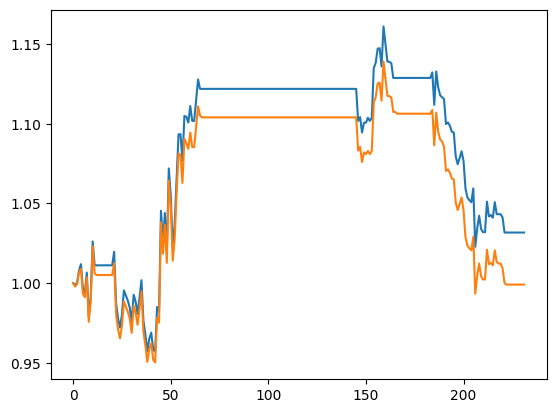

In [12]:
gross_returns = np.array([])
net_returns = np.array([])
t_s = np.array([])
stock1 = stocks[0]
stock2 = stocks[1]
for t in range(window, len(data)):
    #defining unit root function stock2 = a + b*stock1
    def unit_root(b):
        a = np.average(data[stock2][t-window:t] - b*data[stock1][t-window:t])
        fair_value = a + b*data[stock1][t-window:t]
        diff = np.array(fair_value - data[stock2][t-window:t])
        diff_diff = diff[1:] - diff[:-1]
        reg = sm.OLS(diff_diff, diff[:-1])
        res = reg.fit()
        return res.params[0] / res.bse[0]
    res1 = spop.minimize(unit_root, data[stock2][t] / data[stock1][t], method = 'Nelder-Mead')
    t_opt = res1.fun
    b_opt = float(res1.x)
    a_opt = np.average(data[stock2][t-window:t] - b_opt*data[stock1][t-window:t])
    fair_value = a_opt + b_opt*data[stock1][t]
    if t == window:
        old_signal = 0
    if t_opt > t_threshold:
        signal = 0
        gross_return = 0
    else:
        signal = np.sign(fair_value - data[stock2][t])
        gross_return = signal*returns[stock2][t] - signal*returns[stock1][t]
    fees = fee*abs(signal - old_signal)
    net_return = gross_return - fees
    gross_returns = np.append(gross_returns, gross_return)
    net_returns = np.append(net_returns, net_return)
    t_s = np.append(t_s, t_opt)
    print('day'+str(data.index[t]))
    if signal == 0:
        print('No trading')
    elif signal == 1:
        print('Log position on ' +stock2+ 'short position on ' +stock1)
    else:
        print('Log position on ' +stock1+ 'short position on ' +stock2)
    print('gross daily return:' +str(round(gross_return*100, 2)) +'%')
    print('net daily return:' +str(round(net_return*100, 2)) +'%')
    print('cummulative net return so far:' +str(round(np.prod(1+net_return)*100 - 100, 2)) +'%')
    print('')
    old_signal = signal
plt.plot(np.append(1, np.cumprod(1+gross_returns))) 
plt.plot(np.append(1, np.cumprod(1+net_returns))) 